# Tutorial: Nonlinear relativistic case, acceleration

### First import all classes necessary for simulation

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

# Main classes for simulation, plasma, driver field and species
from qsa_pwfa.simulation import Simulation
from qsa_pwfa.species import NeutralUniformPlasma
from qsa_pwfa.external_fields import GaussianBunchField
from qsa_pwfa.species import GaussianBunch

# Diagnostics
from qsa_pwfa.diagnostics import FieldDiagnostics
from qsa_pwfa.diagnostics import BunchDiagnostics
from qsa_pwfa.diagnostics import SpeciesDiagnostics

### Code space and time units are normalized to plasma $k_p^{-1}$, $\omega_p^{-1}$. For this example let us consider input in SI units corresponding to plasma density $2\cdot 10^{18}$ cm$^{-3}$.

In [2]:
n_plasma = 2e18 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

### Let us define a driver and witness beams

In [3]:
Q_drv = 200e-12 # Beam charge in [C]

sigma_R_drv = 2e-6 / k_p_inv   # beam radius of []
sigma_Xi_drv = 2e-6 / k_p_inv
n_drv = Q_drv / e / (2*np.pi)**1.5 / (k_p_inv*sigma_R_drv)**2 / (k_p_inv*sigma_Xi_drv) / n_plasma 

Q_trl = 10e-12 # Beam charge in [C]
sigma_R_trl = 1e-6 / k_p_inv   # beam radius of []
sigma_Xi_trl = 0.3e-6 / k_p_inv
n_trl = Q_trl / e / (2*np.pi)**1.5 / (k_p_inv*sigma_R_trl)**2 / (k_p_inv*sigma_Xi_trl) / n_plasma 

gamma_trl = 200/0.511
delta_gamma_rel = 0.005
delta_theta = 4e-3

dt_trl = 2 * np.pi * (2 * gamma_trl)**.5 / 20

N_steps = int(np.round(750e-6 / k_p_inv / dt_trl))

### and uniform plasma with a longitudinal and transverse sizes of 3 plasma waves

In [4]:
# plasma
L_xi = 1.5 * (2*np.pi)
L_r = 0.5 * (2*np.pi)

# grid
N_xi = 512 * 2
N_r = 512 * 2

d_xi = L_xi / N_xi
dr = L_r / N_r

In [5]:
driver_bunch = GaussianBunchField(n_drv, sigma_R_drv, sigma_Xi_drv)
plasma = NeutralUniformPlasma(L_r=L_r, N_r=N_r)

xi1 = driver_bunch.xi_0 + 2 * np.pi - 1. - 5*sigma_Xi_trl
xi2 = 8.2 # driver_bunch.xi_0 + 2 * np.pi - 1. + 5*sigma_Xi_trl
N_xi_hires = 512

sim = Simulation(L_xi=L_xi, N_xi=N_xi, dt=dt_trl)

xi_grid = sim.xi.copy()
xi_grid_before = xi_grid[xi_grid<=xi1]
xi_grid_after = xi_grid[xi_grid>=xi2]
xi_grid_middle = np.r_[xi_grid_before[-1] : xi_grid_after[0] : N_xi_hires*1j]
xi_grid_user = np.r_[
    xi_grid_before[:-1],
    xi_grid_middle,
    xi_grid_after[1:] 
]

sim = Simulation(xi_grid_user=xi_grid_user, dt=dt_trl)

### Now lets setup and run the simulation

In [6]:
witness_bunch = GaussianBunch(sim, n_trl, sigma_R_trl, sigma_Xi_trl, 
                              xi_0 = driver_bunch.xi_0 + 2 * np.pi - 1.,
                              gamma_b=gamma_trl,
                              delta_gamma=delta_gamma_rel*gamma_trl,
                              eps_r=delta_theta*gamma_trl*sigma_R_trl,
                             )

sim.add_specie( plasma )
sim.add_specie( witness_bunch )
sim.add_external_field( driver_bunch )

sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r, N_r=N_r//2,
                      fields=['Density', ], 
                      xi_step=2, dt_step=N_steps-1
                      ),
    BunchDiagnostics( sim, witness_bunch, 
                      fields=['p_z','p_r'],
                      xi_step=1, dt_step=N_steps-1 )
]

sim.run_steps(N_steps)

  0%|          | 0/32292 [00:00<?, ?it/s]

reached max PC iterations at i_xi=1136 (xi=7.882217687381238), with an error 0.011783
reached max PC iterations at i_xi=1141 (xi=7.89392517284651), with an error 0.010212
reached max PC iterations at i_xi=1146 (xi=7.905632658311783), with an error 0.0209952
reached max PC iterations at i_xi=1122 (xi=7.8494367280784765), with an error 0.0269417
reached max PC iterations at i_xi=1122 (xi=7.8494367280784765), with an error 0.0118336
reached max PC iterations at i_xi=1143 (xi=7.898608167032619), with an error 0.0112639


### Now we plot the electron density

<IPython.core.display.Javascript object>


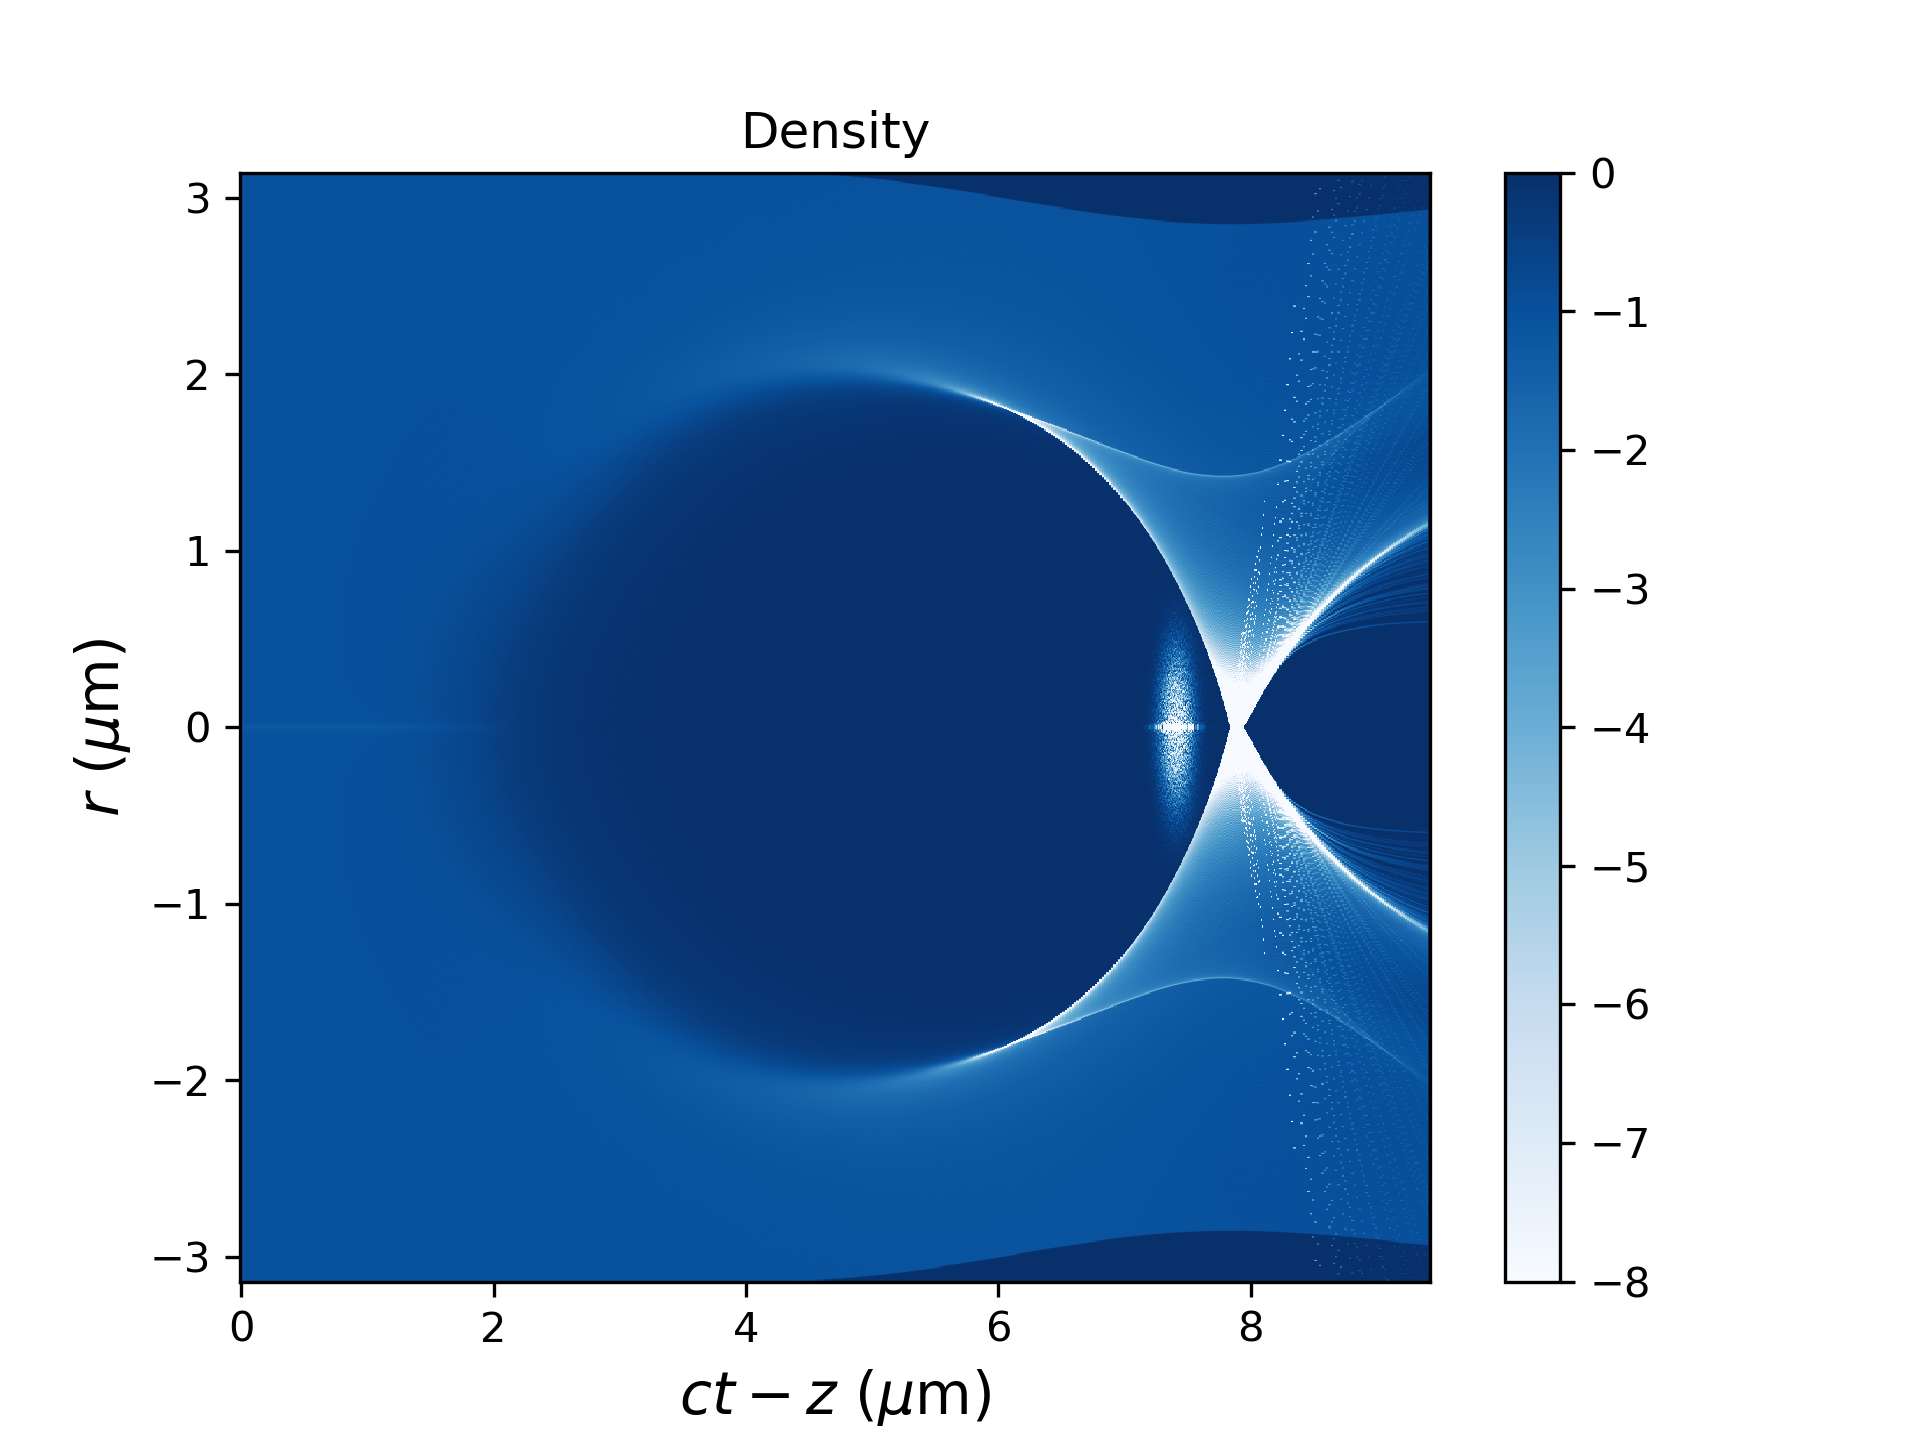

<IPython.core.display.Javascript object>


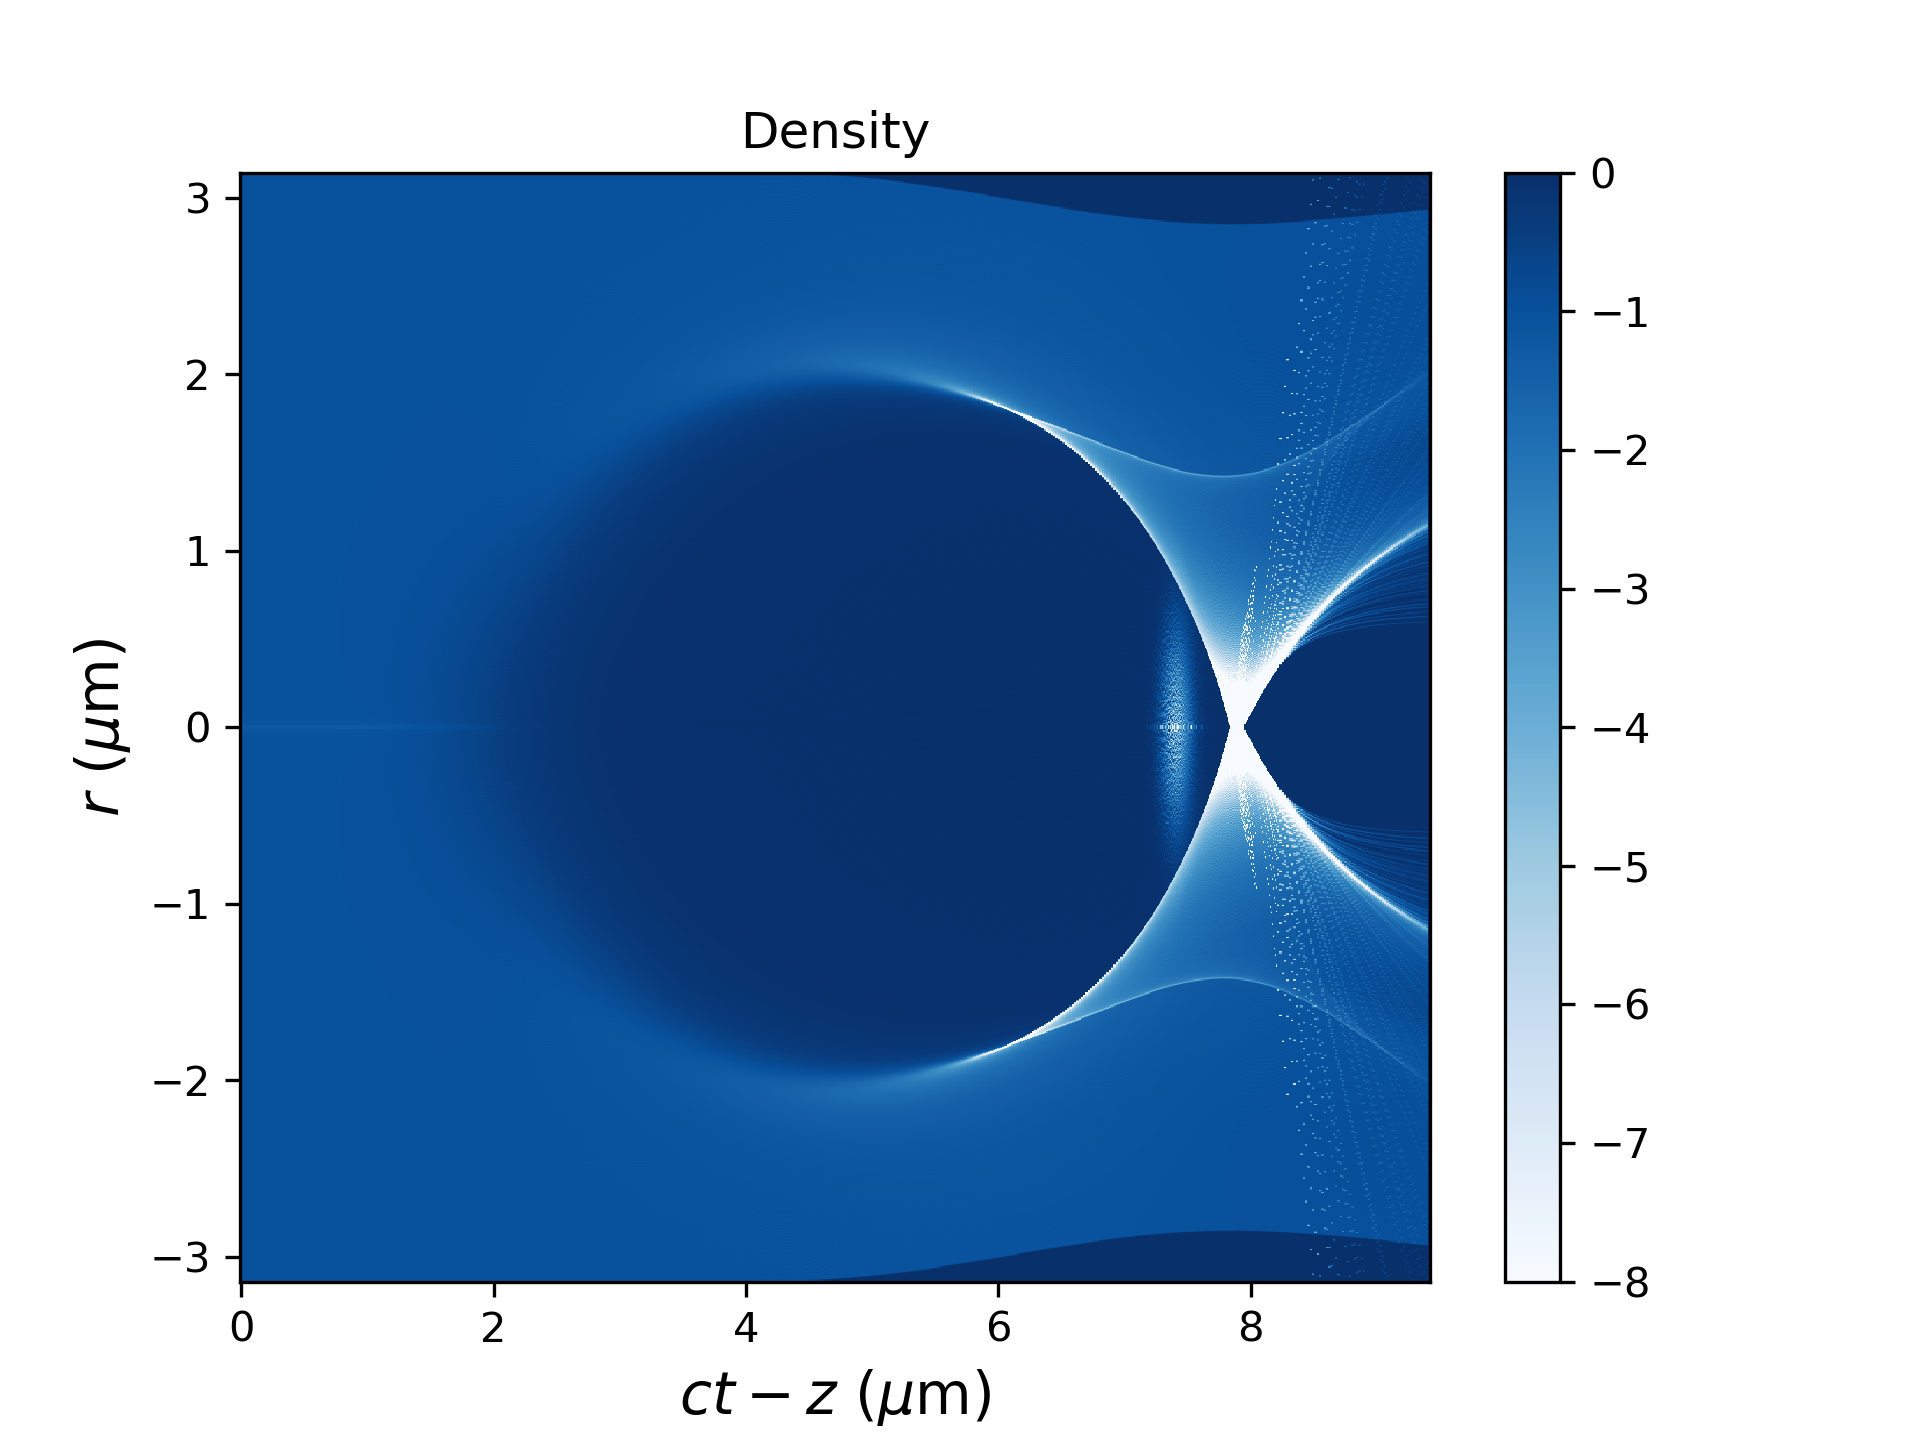

In [7]:
diag = sim.diagnostics[0]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                -diag.grid.rmax,
                 diag.grid.rmax ]) * k_p_inv * 1e6

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs):
        val = outout[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))
        r_grid = np.hstack((-diag.grid.r0[1:][::-1], diag.grid.r0[1:]))
        
        plt.figure(dpi=150)

        vmin = -8
        plt.pcolormesh(diag.xi, r_grid, val_ext.T,
                #origin='lower',
                #aspect='auto',
                cmap=plt.cm.Blues,
                vmax=0,
                vmin=vmin,
                shading='nearest',
                #extent=ext
                )

        plt.colorbar()
        plt.xlabel(r'$ct-z$ ($\mu$m)', fontsize=14)
        plt.ylabel(r'$r$ ($\mu$m)', fontsize=14)

        plt.title(f"{fld}")

<IPython.core.display.Javascript object>


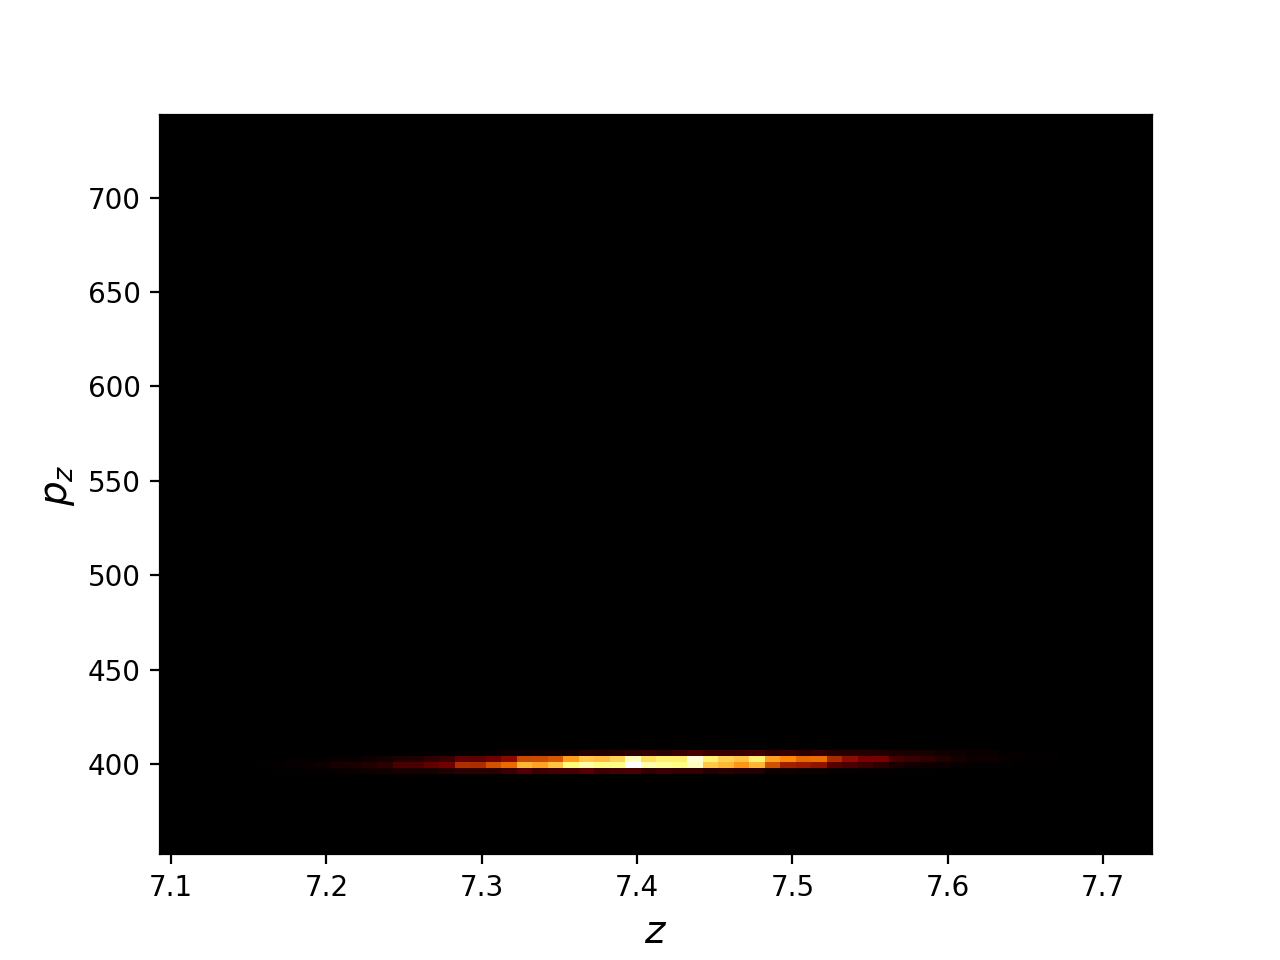

<IPython.core.display.Javascript object>


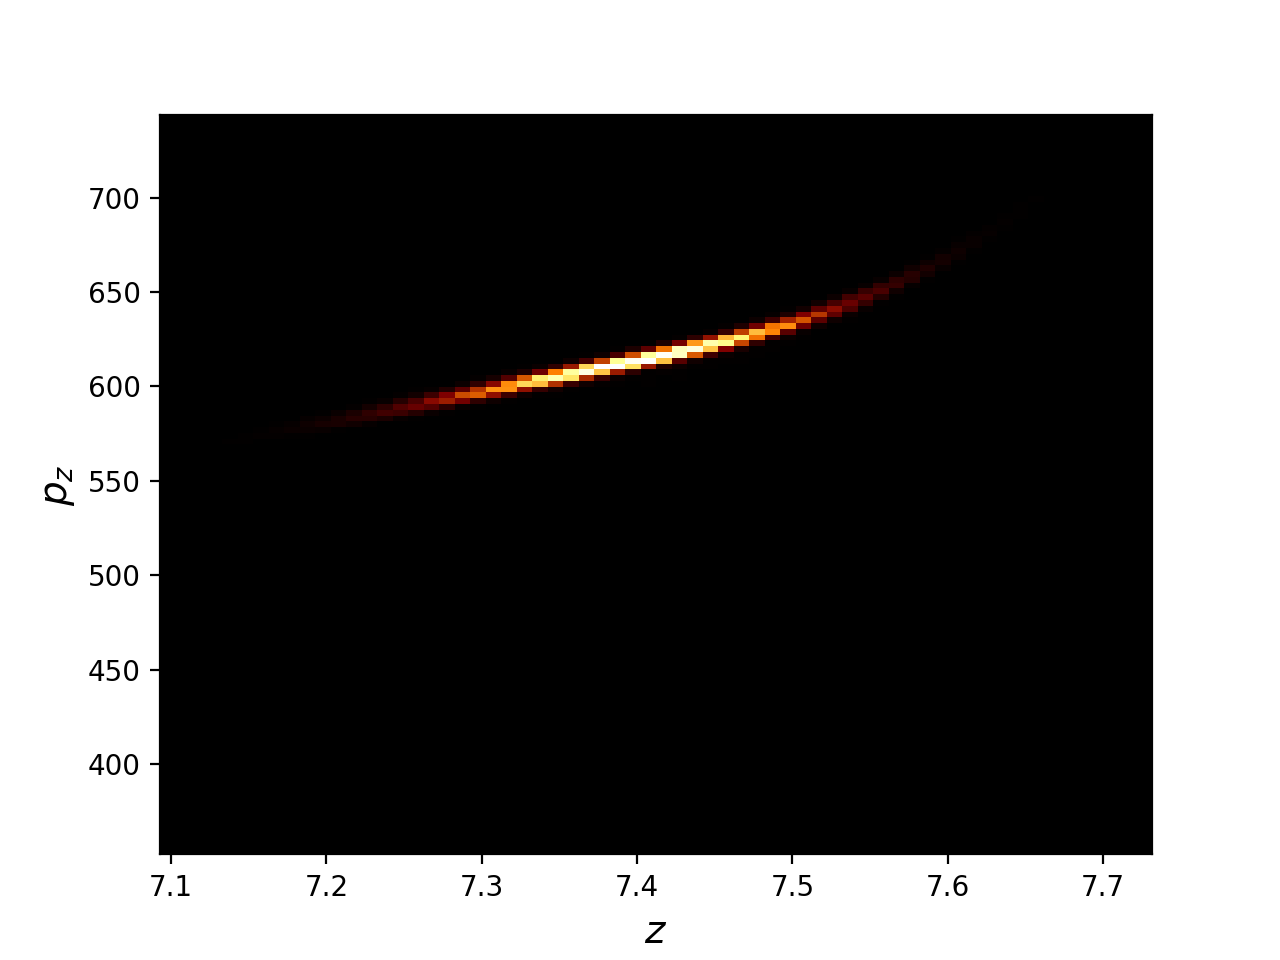

In [9]:
for outout in np.array(sim.diagnostics[-1].outputs)[[0,-1]]:

    z, pz, w = outout['xi'].flatten(), \
        outout['p_z'].flatten(), \
        outout['dQ'].flatten()

    plt.figure()
    plt.hist2d(z, pz, weights=w, bins=(64, 128),
               range=[[witness_bunch.xi_0 - 4*sigma_Xi_trl, witness_bunch.xi_0 + 4*sigma_Xi_trl],
                      [0.9*gamma_trl, 1.9*gamma_trl]],
               cmap=plt.cm.afmhot_r );
    plt.xlabel(r'$z$', size=14)
    plt.ylabel(r'$p_z$', size=14)